# **Conhecendo o Dataset MovieLens**

In [ ]:
#instalando biblioteca surprise

!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 17.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633971 sha256=898eb56a61aad3234705ec96b042d6f5a22cecd6a0ebaef2df5684249d809646
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
#importando dependências
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import time, math
import os
import csv
import sys
import re
import itertools
import heapq
import math
import random
from surprise import Dataset
from surprise import Reader
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline
from surprise import KNNBasic
from operator import itemgetter
from surprise import AlgoBase
from surprise import PredictionImpossible
from surprise import SVD
from surprise import NormalPredictor
from surprise import SVD, SVDpp





## Carregando MovieLens com 100 mil registros.

In [ ]:
#Descompactando os dados
!wget -nc https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -n ml-latest-small.zip

File ‘ml-latest-small.zip’ already there; not retrieving.

Archive:  ml-latest-small.zip


In [ ]:
#criando os datasets principais
movie_dataset = pd.read_csv('/content/ml-latest-small/movies.csv')
ratings_dataset = pd.read_csv('/content/ml-latest-small/ratings.csv')
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movieId')
merged_dataset.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Quantos usuários, filmes e avaliações temos na base?

In [ ]:
print("Temos a seguinte volumetria por coluna do arquivo Movielens:",ratings_dataset.userId.count(),"Avaliações",ratings_dataset.userId.nunique(), "usuários",ratings_dataset.movieId.nunique(), "filmes")

Temos a seguinte volumetria por coluna do arquivo Movielens: 100836 Avaliações 610 usuários 9724 filmes


## No arquivo temos 100.836 avaliações de 610 usuários em 9724 filmes.

Cada usuário avaliou pelo menos 20 filmes.

## Visualização de dados e recomendações por meio de análise de dados para um novo usuário (sistema de recomendação baseado em popularidade)

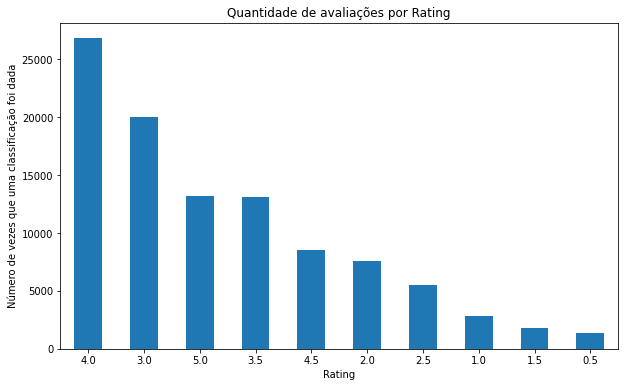

In [ ]:
merged_dataset['rating'].value_counts(sort=True).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
plt.title('Quantidade de avaliações por Rating')
plt.xlabel('Rating')
plt.ylabel('Número de vezes que uma classificação foi dada')
label = list(merged_dataset['rating'].value_counts(sort=True))




Podemos observar que a maioria dos usuários avaliaram os filmes que assistiram com uma classificação de 4 estrelas e seguidas de 3 estrelas e 5 estrelas.

In [ ]:
#Criando dataset agrupando pelo nome do filme e pela média de rating
avg_highly_rated_movies = merged_dataset.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()
avg_highly_rated_movies.head()

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0


In [ ]:
avg_highly_rated_movies.head(20)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


In [ ]:
print("Número de filmes com classificação média de 5 estrelas: ",len(avg_highly_rated_movies[avg_highly_rated_movies['rating'] == 5.0]))
print("Número de filmes com classificação média acima de 4 estrelas e abaixo de 5 estrelas: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 4.0) & (avg_highly_rated_movies['rating'] < 5.0)]))
print("Número de filmes com classificação média acima de 3 estrelas e abaixo de 4 estrelas: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 3.0) & (avg_highly_rated_movies['rating'] < 4.0)]))
print("Número de filmes com classificação média acima de 2 estrelas e abaixo de 3 estrelas: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 2.0) & (avg_highly_rated_movies['rating'] < 3.0)]))
print("Número de filmes com classificação acima de 1 estrela e abaixo de 2 estrelas em média: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 1.0) & (avg_highly_rated_movies['rating'] < 2.0)]))
print("Número de filmes com classificação média abaixo de 1 estrela: ", len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] < 1.0)]))


Número de filmes com classificação média de 5 estrelas:  296
Número de filmes com classificação média acima de 4 estrelas e abaixo de 5 estrelas:  1972
Número de filmes com classificação média acima de 3 estrelas e abaixo de 4 estrelas:  4694
Número de filmes com classificação média acima de 2 estrelas e abaixo de 3 estrelas:  2121
Número de filmes com classificação acima de 1 estrela e abaixo de 2 estrelas em média:  528
Número de filmes com classificação média abaixo de 1 estrela:  108


Podemos ver o número de filmes entre cada intervalo de classificações médias:  
rating igual 5.0 : 296;  
rating maior ou igual 4 e menor que 5: 1972;  
rating maior ou igual 3 e menor que 4: 4694;    
rating maior ou igual 2 e menor que 3: 2121;  
rating maior ou igual 1 e menor que 2: 528;
rating menor que 1: 108 


Percentual por faixa de Rating


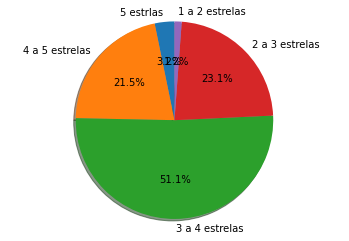

In [ ]:
#Gráfico de pizza para mostrar a distribuição das avaliações por faixa de rating

print('Percentual por faixa de Rating')

labels = '5 estrlas', '4 a 5 estrelas', '3 a 4 estrelas', '2 a 3 estrelas', '1 a 2 estrelas'
sizes = [296, 1972, 4694, 2121, 108]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()


In [ ]:
avg_highly_rated_movies.reset_index(level=0, inplace=True)

In [ ]:
avg_highly_rated_movies.columns = ['title', 'avg rating']

avg_highly_rated_movies.head(10)

,title,avg rating
0,Gena the Crocodile (1969),5.0
1,True Stories (1986),5.0
2,Cosmic Scrat-tastrophe (2015),5.0
3,Love and Pigeons (1985),5.0
4,Red Sorghum (Hong gao liang) (1987),5.0
5,"Thin Line Between Love and Hate, A (1996)",5.0
6,Lesson Faust (1994),5.0
7,Eva (2011),5.0
8,Who Killed Chea Vichea? (2010),5.0
9,Siam Sunset (1999),5.0


**Recomendações baseadas nas classificações médias superiores.**

-----------------------------

In [ ]:
merged_dataset.groupby(['title']).agg({"rating":"sum"})['rating'].sort_values(ascending=False)

title
Shawshank Redemption, The (1994)    1404.0
Forrest Gump (1994)                 1370.0
Pulp Fiction (1994)                 1288.5
Matrix, The (1999)                  1165.5
Silence of the Lambs, The (1991)    1161.0
                                     ...  
Uncle Nino (2003)                      0.5
Legionnaire (1998)                     0.5
Ring of Terror (1962)                  0.5
Glitter (2001)                         0.5
Begotten (1990)                        0.5
Name: rating, Length: 9719, dtype: float64

In [ ]:
popular_movies = merged_dataset.groupby(['title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)


In [ ]:
popular_movies = popular_movies.to_frame()
popular_movies.reset_index(level=0, inplace=True)
popular_movies.columns = ['title', 'Number of Users watched']

In [ ]:
print("Número de filmes com mais de 300 e menos de 399 espectadores: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 300) & (popular_movies['Number of Users watched'] < 400)]))
print("Número de filmes com mais de 200 e menos de 299 espectadores: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 200) & (popular_movies['Number of Users watched'] < 300)]))
print("Número de filmes com mais de 100 e menos de 199 espectadores: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 100) & (popular_movies['Number of Users watched'] < 200)]))
print("Número de filmes com menos de 100 espectadores: ", len(popular_movies[(popular_movies['Number of Users watched'] < 100)]))


Número de filmes populares com mais de 300 e menos de 400 espectadores:  3
Número de filmes populares com mais de 200 e menos de 300 espectadores:  16
Número de filmes populares com mais de 100 e menos de 200 espectadores:  119
Número de filmes populares com menos de 100 espectadores:  9581


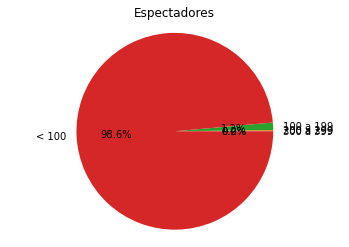

In [ ]:

sizes = [3,16,119,9581]
labels = '300 a 399', '200 a 299', '100 a 199', '< 100'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=360)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Espectadores')


plt.show()





Podemos considerar como **POPULAR** os filmes que têm mais de 200 espectadores e no caso são 19 filmes.

-------------------------

In [ ]:
popular_movies[popular_movies['Number of Users watched'] >= 200]

,title,Number of Users watched
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


Estes são os filmes mais populares que podem ser recomendados para um novo usuário. **Recomendações com base na popularidade**

----------------------------

In [ ]:
#Unindo dataset com as melhores médias de rating com os filmes mais assistidos.
highly_rated_popular_movies = pd.merge(avg_highly_rated_movies, popular_movies, how = 'inner', on='title')
highly_rated_popular_movies.head(10)

,title,avg rating,Number of Users watched
0,Gena the Crocodile (1969),5.0,1
1,True Stories (1986),5.0,1
2,Cosmic Scrat-tastrophe (2015),5.0,1
3,Love and Pigeons (1985),5.0,1
4,Red Sorghum (Hong gao liang) (1987),5.0,1
5,"Thin Line Between Love and Hate, A (1996)",5.0,1
6,Lesson Faust (1994),5.0,2
7,Eva (2011),5.0,1
8,Who Killed Chea Vichea? (2010),5.0,1
9,Siam Sunset (1999),5.0,1


In [ ]:
avg_highly_rated_movies.head(10)

,title,avg rating
0,Gena the Crocodile (1969),5.0
1,True Stories (1986),5.0
2,Cosmic Scrat-tastrophe (2015),5.0
3,Love and Pigeons (1985),5.0
4,Red Sorghum (Hong gao liang) (1987),5.0
5,"Thin Line Between Love and Hate, A (1996)",5.0
6,Lesson Faust (1994),5.0
7,Eva (2011),5.0
8,Who Killed Chea Vichea? (2010),5.0
9,Siam Sunset (1999),5.0


In [ ]:
highly_rated_popular_movies[highly_rated_popular_movies['Number of Users watched']>200]

,title,avg rating,Number of Users watched
722,"Shawshank Redemption, The (1994)",4.429022,317
808,Fight Club (1999),4.272936,218
933,"Usual Suspects, The (1995)",4.237745,204
935,Star Wars: Episode IV - A New Hope (1977),4.231076,251
940,Schindler's List (1993),4.225000,220
949,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211
971,Pulp Fiction (1994),4.197068,307
972,"Matrix, The (1999)",4.192446,278
1035,Forrest Gump (1994),4.164134,329
1038,"Silence of the Lambs, The (1991)",4.161290,279


In [ ]:
highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>200) & (highly_rated_popular_movies['avg rating']>=4.0)]

,title,avg rating,Number of Users watched
722,"Shawshank Redemption, The (1994)",4.429022,317
808,Fight Club (1999),4.272936,218
933,"Usual Suspects, The (1995)",4.237745,204
935,Star Wars: Episode IV - A New Hope (1977),4.231076,251
940,Schindler's List (1993),4.225000,220
949,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211
971,Pulp Fiction (1994),4.197068,307
972,"Matrix, The (1999)",4.192446,278
1035,Forrest Gump (1994),4.164134,329
1038,"Silence of the Lambs, The (1991)",4.161290,279


Esses filmes são os melhores para sugerir a um novo usuário, pois são populares e bem avaliados pelos usuários que já os assistiram. Estes têm classificação superior a 4 e com pelo mais de 200 espectadores.

**Popularidade e classificação baseadas em recomendações. Estes são os filmes populares mais bem avaliados**

----------------------------


###Criando função para inserir novos usuários e avaliações no datset

In [ ]:
def add_rating(userId:str,movie_name:str, rating:float):
    # Procura o filme
    movie_details = movie_dataset.loc[movie_dataset['title'] == movie_name]
    timestamp1 = merged_dataset.loc[merged_dataset['title'] == movie_name]
    timestamp2 = timestamp1[['timestamp']]
    
    if movie_details.shape[0] == 0:
        raise Exception('Não foi encontrado filme com este nome')
    elif movie_details.shape[0] >= 2:
        msg = 'Foram encontrados mais de um filme.\n'
        msg += '\n'.join(movie_details['title'])
        raise Exception(msg)
        
    last_index = max(merged_dataset.index) + 1
    
    merged_dataset.loc[last_index, 'userId'] = userId
    merged_dataset.loc[last_index, 'movieId'] = movie_details['movieId'].values[0]
    merged_dataset.loc[last_index, 'rating'] = rating
    merged_dataset.loc[last_index, 'title'] = movie_name
    merged_dataset.loc[last_index, 'timestamp'] = timestamp2['timestamp'].values[0]

    
    update_csv = pd.DataFrame([[userId, movie_details['movieId'].values[0], rating, timestamp2['timestamp'].values[0]]],columns=['userId','movieId','rating', 'timestamp'])

    update_csv.to_csv('/content/ml-latest-small/ratings.csv',sep=',', mode='a', index=False, header=False)
    
    merged_dataset.reset_index(inplace=True, drop=True)
    
  

In [ ]:
user_notas = [
    
    ['Thank You for Smoking (2006)',5],
    ['Find Me Guilty (2006)',5],
    ['Inside Man (2006)',2],
    ['Aquamarine (2006)',1],
    ['Lights in the Dusk (Laitakaupungin valot) (2006)',1],
    ['Take the Lead (2006)',2],
    ['Leap Year (2010)',5],
    ['Legion (2010)',2],
    ['When in Rome (2010)',3],
    ['Temple Grandin (2010)',3],
    ['Shutter Island (2010)',4],
    ['Jupiter Ascending (2015)',3],
    ['Ex Machina (2015)',1],
    ['In the Heart of the Sea (2015)',2],
    ['Jurassic World (2015)',2],
    ['Maze Runner: Scorch Trials (2015)',3],
    ['Avengers: Age of Ultron (2015)',5],
    ['Iron Man (2008)',5],
    ['Iron Man 2 (2010)',5],
    ['Iron Man 3 (2013)', 5]

]

for movie_name, rating in user_notas:
    add_rating(611, movie_name, rating)



### Criando classe Movielens contendo as funções que retornam avaliação do usuário, avaliações populares, gênero e ano de lançamento do filme:
 

In [ ]:



class MovieLens:

    movieID_to_name = {}
    name_to_movieID = {}
    ratingsPath = '/content/ml-latest-small/ratings.csv'
    moviesPath = '/content/ml-latest-small/movies.csv'
    
    def loadMovieLensLatestSmall(self):

        # Look for files relative to the directory we are running from
        os.chdir(os.path.dirname(sys.argv[0]))

        ratingsDataset = 0
        self.movieID_to_name = {}
        self.name_to_movieID = {}

        reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
                movieReader = csv.reader(csvfile)
                next(movieReader)  #Skip header line
                for row in movieReader:
                    movieID = int(row[0])
                    movieName = row[1]
                    self.movieID_to_name[movieID] = movieName
                    self.name_to_movieID[movieName] = movieID

        return ratingsDataset

    def getUserRatings(self, user):
        userRatings = []
        hitUser = False
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                userID = int(row[0])
                if (user == userID):
                    movieID = int(row[1])
                    rating = float(row[2])
                    userRatings.append((movieID, rating))
                    hitUser = True
                if (hitUser and (user != userID)):
                    break

        return userRatings

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = defaultdict(int)
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                movieID = int(row[1])
                ratings[movieID] += 1
        rank = 1
        for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
        return rankings
    
    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)  #Skip header line
            for row in movieReader:
                movieID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[movieID] = genreIDList
        # Convert integer-encoded genre lists to bitfields that we can treat as vectors
        for (movieID, genreIDList) in genres.items():
            bitfield = [0] * maxGenreID
            for genreID in genreIDList:
                bitfield[genreID] = 1
            genres[movieID] = bitfield            
        
        return genres
    
    def getYears(self):
        p = re.compile(r"(?:\((\d{4})\))?\s*$")
        years = defaultdict(int)
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                title = row[1]
                m = p.search(title)
                year = m.group(1)
                if year:
                    years[movieID] = int(year)
        return years
    
    def getMiseEnScene(self):
        mes = defaultdict(list)
        with open("/content/LLVisualFeatures13K_Log.csv", newline='') as csvfile:
            mesReader = csv.reader(csvfile)
            next(mesReader)
            for row in mesReader:
                movieID = int(row[0])
                avgShotLength = float(row[1])
                meanColorVariance = float(row[2])
                stddevColorVariance = float(row[3])
                meanMotion = float(row[4])
                stddevMotion = float(row[5])
                meanLightingKey = float(row[6])
                numShots = float(row[7])
                mes[movieID] = [avgShotLength, meanColorVariance, stddevColorVariance,
                   meanMotion, stddevMotion, meanLightingKey, numShots]
        return mes
    
    def getMovieName(self, movieID):
        if movieID in self.movieID_to_name:
            return self.movieID_to_name[movieID]
        else:
            return ""
        
    def getMovieID(self, movieName):
        if movieName in self.name_to_movieID:
            return self.name_to_movieID[movieName]
        else:
            return 0

## Metricas


In [ ]:


class RecommenderMetrics:

    #retorna Erro Absoluto Médio
    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)

    #retorna a raiz quadrática média
    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    #retorna top 10 recomendações
    def GetTopN(predictions, n=10, minimumRating=0.0):
        topN = defaultdict(list)


        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))

        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN
   #Retorna os filmes que o algoritmo recomendou e que o usuário classificou
    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # Compute overall precision
        return hits/total
    #Retorna os filmes que o algoritmo recomendou e que o usuário classificou
    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Only look at ability to recommend things the users actually liked...
            if (actualRating >= ratingCutoff):
                # Is it in the predicted top 10 for this user?
                hit = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == movieID):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # Compute overall precision
        return hits/total

    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1

            total[actualRating] += 1

        # Compute overall precision
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])

    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hitRank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutMovieID) == movieID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank

            total += 1

        return summation / total

    # Qual porcentagem de usuários tem pelo menos uma recomendação "boa"
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for movieID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1

        return hits / numUsers

 


##Algoritmo que calcula a acuracia do modelo.

In [ ]:


class EvaluatedAlgorithm:
    
    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name
        
    def Evaluate(self, evaluationData, doTopN, n=10, verbose=True):
        metrics = {}
        # Compute accuracy
        if (verbose):
            print("Evaluating accuracy...")
        self.algorithm.fit(evaluationData.GetTrainSet())
        predictions = self.algorithm.test(evaluationData.GetTestSet())
        metrics["RMSE"] = RecommenderMetrics.RMSE(predictions)
        metrics["MAE"] = RecommenderMetrics.MAE(predictions)
        
        if (doTopN):
            # Evaluate top-10 with Leave One Out testing
            if (verbose):
                print("Evaluating top-N with leave-one-out...")
            self.algorithm.fit(evaluationData.GetLOOCVTrainSet())
            leftOutPredictions = self.algorithm.test(evaluationData.GetLOOCVTestSet())        
            # Build predictions for all ratings not in the training set
            allPredictions = self.algorithm.test(evaluationData.GetLOOCVAntiTestSet())
            # Compute top 10 recs for each user
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Computing hit-rate and rank metrics...")
            # See how often we recommended a movie the user actually rated
            metrics["HR"] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)   
            # See how often we recommended a movie the user actually liked
            metrics["cHR"] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions)
            # Compute ARHR
            metrics["ARHR"] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)
        
            #Evaluate properties of recommendations on full training set
            if (verbose):
                print("Computing recommendations with full data set...")
            self.algorithm.fit(evaluationData.GetFullTrainSet())
            allPredictions = self.algorithm.test(evaluationData.GetFullAntiTestSet())
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Analyzing coverage, diversity, and novelty...")
            # Print user coverage with a minimum predicted rating of 4.0:
            metrics["Coverage"] = RecommenderMetrics.UserCoverage(  topNPredicted, 
                                                                   evaluationData.GetFullTrainSet().n_users, 
                                                                   ratingThreshold=4.0)
            # Measure diversity of recommendations:
            metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, evaluationData.GetSimilarities())
            
            # Measure novelty (average popularity rank of recommendations):
            metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted, 
                                                            evaluationData.GetPopularityRankings())
        
        if (verbose):
            print("Analysis complete.")
    
        return metrics
    
    def GetName(self):
        return self.name
    
    def GetAlgorithm(self):
        return self.algorithm
    
    

#Separando o arquivo de treino e o arquivo de teste

In [ ]:


class EvaluationData:
    
    def __init__(self, data, popularityRankings):
        
        self.rankings = popularityRankings
        
        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()
        
        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)
        
        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test
            
        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()
        
        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)
            
    def GetFullTrainSet(self):
        return self.fullTrainSet
    
    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet
    
    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet
    
    def GetTestSet(self):
        return self.testSet
    
    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain
    
    def GetLOOCVTestSet(self):
        return self.LOOCVTest
    
    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet
    
    def GetSimilarities(self):
        return self.simsAlgo
    
    def GetPopularityRankings(self):
        return self.rankings

##Classe que recebe qual é o algoritmo que tem que ser executado da lib surprise

In [ ]:
class Evaluator:
    
    algorithms = []
    
    def __init__(self, dataset, rankings):
        ed = EvaluationData(dataset, rankings)
        self.dataset = ed
        
    def AddAlgorithm(self, algorithm, name):
        alg = EvaluatedAlgorithm(algorithm, name)
        self.algorithms.append(alg)
        
    def Evaluate(self, doTopN):
        results = {}
        for algorithm in self.algorithms:
            print("Evaluating ", algorithm.GetName(), "...")
            results[algorithm.GetName()] = algorithm.Evaluate(self.dataset, doTopN)

        # Print results
        print("\n")
        
        if (doTopN):
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                    "Algorithm", "RMSE", "MAE", "HR", "cHR", "ARHR", "Coverage", "Diversity", "Novelty"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["cHR"], metrics["ARHR"],
                                      metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
        else:
            print("{:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f}".format(name, metrics["RMSE"], metrics["MAE"]))
                
        print("\nLegend:\n")
        print("RMSE:      Root Mean Squared Error. Lower values mean better accuracy.")
        print("MAE:       Mean Absolute Error. Lower values mean better accuracy.")
        if (doTopN):
            print("HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.")
            print("cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.")
            print("ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better." )
            print("Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.")
            print("Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations")
            print("           for a given user. Higher means more diverse.")
            print("Novelty:   Average popularity rank of recommended items. Higher means more novel.")
        
    def SampleTopNRecs(self, ml, testSubject:int, k=10):
        
        for algo in self.algorithms:
            print("\nUsing recommender ", algo.GetName())
            
            print("\nBuilding recommendation model...")
            trainSet = self.dataset.GetFullTrainSet()
            algo.GetAlgorithm().fit(trainSet)
            
            print("Computing recommendations...")
            testSet = self.dataset.GetAntiTestSetForUser(testSubject)
        
            predictions = algo.GetAlgorithm().test(testSet)
            
            recommendations = []
            
            print ("\nWe recommend:")
            for userID, movieID, actualRating, estimatedRating, _ in predictions:
                intMovieID = int(movieID)
                recommendations.append((intMovieID, estimatedRating))
            
            recommendations.sort(key=lambda x: x[1], reverse=True)
            
            for ratings in recommendations[:10]:
                print(ml.getMovieName(ratings[0]), ratings[1])
                

            
            
    
    

#Algoritmo hibrido

In [ ]:
class HybridAlgorithm(AlgoBase):

    def __init__(self, algorithms, weights, sim_options={}):
        AlgoBase.__init__(self)
        self.algorithms = algorithms
        self.weights = weights

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        for algorithm in self.algorithms:
            algorithm.fit(trainset)
                
        return self

    def estimate(self, u, i):
        
        sumScores = 0
        sumWeights = 0
        
        for idx in range(len(self.algorithms)):
            sumScores += self.algorithms[idx].estimate(u, i) * self.weights[idx]
            sumWeights += self.weights[idx]
            
        return sumScores / sumWeights

    

##KNN - K-NEAREST NEIGHBORS

Como o classificador KNN prediz a classe de uma determinada observação de teste, identificando as observações mais próximas a ela, a escala das variáveis é importante.

In [ ]:
class ContentKNNAlgorithm(AlgoBase):

    def __init__(self, k=40, sim_options={}):
        AlgoBase.__init__(self)
        self.k = k

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        # Compute item similarity matrix based on content attributes

        # Load up genre vectors for every movie
        ml = MovieLens()
        genres = ml.getGenres()
        years = ml.getYears()
        mes = ml.getMiseEnScene()
        
        print("Computing content-based similarity matrix...")
            
        # Compute genre distance for every movie combination as a 2x2 matrix
        self.similarities = np.zeros((self.trainset.n_items, self.trainset.n_items))
        
        for thisRating in range(self.trainset.n_items):
            if (thisRating % 100 == 0):
                print(thisRating, " of ", self.trainset.n_items)
            for otherRating in range(thisRating+1, self.trainset.n_items):
                thisMovieID = int(self.trainset.to_raw_iid(thisRating))
                otherMovieID = int(self.trainset.to_raw_iid(otherRating))
                genreSimilarity = self.computeGenreSimilarity(thisMovieID, otherMovieID, genres)
                yearSimilarity = self.computeYearSimilarity(thisMovieID, otherMovieID, years)
                #mesSimilarity = self.computeMiseEnSceneSimilarity(thisMovieID, otherMovieID, mes)
                self.similarities[thisRating, otherRating] = genreSimilarity * yearSimilarity
                self.similarities[otherRating, thisRating] = self.similarities[thisRating, otherRating]
                
        print("...done.")
                
        return self
    
    def computeGenreSimilarity(self, movie1, movie2, genres):
        genres1 = genres[movie1]
        genres2 = genres[movie2]
        sumxx, sumxy, sumyy = 0, 0, 0
        for i in range(len(genres1)):
            x = genres1[i]
            y = genres2[i]
            sumxx += x * x
            sumyy += y * y
            sumxy += x * y
        
        return sumxy/math.sqrt(sumxx*sumyy)
    
    def computeYearSimilarity(self, movie1, movie2, years):
        diff = abs(years[movie1] - years[movie2])
        sim = math.exp(-diff / 10.0)
        return sim
    
    def computeMiseEnSceneSimilarity(self, movie1, movie2, mes):
        mes1 = mes[movie1]
        mes2 = mes[movie2]
        if (mes1 and mes2):
            shotLengthDiff = math.fabs(mes1[0] - mes2[0])
            colorVarianceDiff = math.fabs(mes1[1] - mes2[1])
            motionDiff = math.fabs(mes1[3] - mes2[3])
            lightingDiff = math.fabs(mes1[5] - mes2[5])
            numShotsDiff = math.fabs(mes1[6] - mes2[6])
            return shotLengthDiff * colorVarianceDiff * motionDiff * lightingDiff * numShotsDiff
        else:
            return 0

    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        
        # Build up similarity scores between this item and everything the user rated
        neighbors = []
        for rating in self.trainset.ur[u]:
            genreSimilarity = self.similarities[i,rating[0]]
            neighbors.append( (genreSimilarity, rating[1]) )
        
        # Extract the top-K most-similar ratings
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])
        
        # Compute average sim score of K neighbors weighted by user ratings
        simTotal = weightedSum = 0
        for (simScore, rating) in k_neighbors:
            if (simScore > 0):
                simTotal += simScore
                weightedSum += simScore * rating
            
        if (simTotal == 0):
            raise PredictionImpossible('No neighbors')

        predictedRating = weightedSum / simTotal

        return predictedRating
    

## TESTANDO ALGORIMO FINAL

In [ ]:

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(0)
random.seed(0)


(ml, evaluationData, rankings) = LoadMovieLensData()


evaluator = Evaluator(evaluationData, rankings)

#SVD++
SVDPlusPlus = SVDpp()

#KNN
ContentKNN = ContentKNNAlgorithm()

#Combine them
Hybrid = HybridAlgorithm([SVDPlusPlus, ContentKNN], [0.5, 0.5])

evaluator.AddAlgorithm(SVDPlusPlus, "SVD++")
evaluator.AddAlgorithm(ContentKNN, "ContentKNN")
evaluator.AddAlgorithm(Hybrid, "Hybrid")

evaluator.Evaluate(False)




Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  SVD++ ...
Evaluating accuracy...
Analysis complete.
Evaluating  ContentKNN ...
Evaluating accuracy...
Computing content-based similarity matrix...
0  of  8775
100  of  8775
200  of  8775
300  of  8775
400  of  8775
500  of  8775
600  of  8775
700  of  8775
800  of  8775
900  of  8775
1000  of  8775
1100  of  8775
1200  of  8775
1300  of  8775
1400  of  8775
1500  of  8775
1600  of  8775
1700  of  8775
1800  of  8775
1900  of  8775
2000  of  8775
2100  of  8775
2200  of  8775
2300  of  8775
2400  of  8775
2500  of  8775
2600  of  8775
2700  of  8775
2800  of  8775
2900  of  8775
3000  of  8775
3100  of  8775
3200  of  8775
3300  of  8775
3400  of  8775
3500  of  8775
3600  of  8775
3700  of  8775
3800  of  8775
3900  of  8775
4000  of  8775
4100  of  8775
4200  of  8775
4300  o

In [ ]:
evaluator.SampleTopNRecs(ml,610)


Using recommender  SVD++

Building recommendation model...
Computing recommendations...

We recommend:
Wallace & Gromit: The Best of Aardman Animation (1996) 5
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion GekijÃ´-ban: Air/Magokoro wo, kimi ni) (1997) 4.967121130563138
12 Angry Men (1957) 4.9646464776643695
Yojimbo (1961) 4.962853400213791
Lawrence of Arabia (1962) 4.904988131814945
Seven Samurai (Shichinin no samurai) (1954) 4.892182863445854
Grand Day Out with Wallace and Gromit, A (1989) 4.881265312339598
Chinatown (1974) 4.83840611902646
Hamlet (1996) 4.8355188025728
Paths of Glory (1957) 4.832415225803963

Using recommender  ContentKNN

Building recommendation model...
Computing content-based similarity matrix...
0  of  9724
100  of  9724
200  of  9724
300  of  9724
400  of  9724
500  of  9724
600  of  9724
700  of  9724
800  of  9724
900  of  9724
1000  of  9724
1100  of  9724
1200  of  9724
1300  of  9724
1400  of  9724
1500  of  9724
1600  of  9724
1700